## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wordnet=WordNetLemmatizer()

##training set import

In [4]:
tweets = pd.read_csv(r'/content/drive/MyDrive/csv files/train_tweets.csv')
tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
tweets = tweets[['selected_text','sentiment']].rename(columns={'selected_text':'text'})
tweets.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [56]:
tweets.shape

(27481, 2)

In [57]:
tweets.isnull().sum()

text         1
sentiment    0
dtype: int64

In [6]:
tweets["text"].fillna("No content", inplace = True)

In [7]:
# Dropping duplicates from text column
tweets.drop_duplicates(subset={'text'}, inplace=True)

## preprocessing text

In [8]:
import string

#Clean the text 
def de_emojify(input_string):
    return input_string.encode('ascii', 'ignore').decode('ascii')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')

def clean_txt(df, text_col='text'):
    # Lower case
    df[text_col] = df[text_col].apply(lambda x: x.lower())
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x: re.sub('@[^\s]+','',x))
    # Remove puntuation
    df[text_col] = df[text_col].apply(lambda x: ''.join([c for c in x if c not in string.punctuation]))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"http\S+", '', x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove Emails
    df[text_col] = df[text_col].apply(lambda x: re.sub('[^\n]*@\S*\s?', '', x))
    # Remove new line characters
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\s+', ' ', x))
    # Remove distracting single quotes
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"\'", '', x))
    # Replace REPLACE_BY_SPACE_RE symbols by space in text
    df[text_col] = df[text_col].apply(lambda x: REPLACE_BY_SPACE_RE.sub(' ', x))
    # Delete symbols which are in BAD_SYMBOLS_RE from text
    df[text_col] = df[text_col].apply(lambda x: BAD_SYMBOLS_RE.sub('', x))
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\B#\S+','',x))

    return df[df[text_col]!='']

In [9]:
tweets = clean_txt(tweets)

In [62]:
tweets.head()

,text,sentiment
0,id have responded if i were going,neutral
1,sooo sad,negative
2,bullying me,negative
3,leave me alone,negative
4,sons of,negative


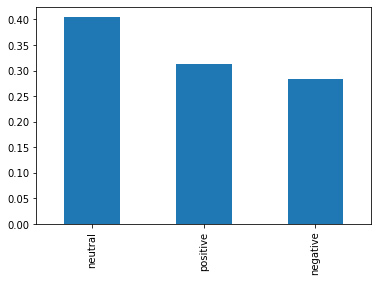

In [175]:
tweets['sentiment'].value_counts(normalize=True).plot.bar();

## model building

In [10]:
X = tweets['text']
y = tweets['sentiment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [65]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16840,) (5614,) (16840,) (5614,)


In [177]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer(ngram_range=[1,1])),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7822921217416631

In [58]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=[1,1])),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(n_jobs=1, loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=400, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7943789136449687

In [179]:
from sklearn.svm import LinearSVC

svm = Pipeline([('vect', CountVectorizer(ngram_range=[1,1])),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(loss = 'hinge', random_state=42, max_iter=1500)),
                ])
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8332605213339158

In [22]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

svc = Pipeline([('vect', CountVectorizer(ngram_range=[1,1])),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=42)),
                ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.836318625309451

In [26]:
from sklearn.model_selection import GridSearchCV
grid_values = {'clf__C':[1e0, 1e1, 1e2], 'clf__gamma': [1, 0.1, 0.01]}
grid_clf_acc = GridSearchCV(svc, param_grid = grid_values, scoring='accuracy', verbose=2)
grid_clf_acc.fit(X_train, y_train)
y_pred = grid_clf_acc.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] clf__C=0.001, clf__gamma=100.0, clf__random_state=42 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=0.001, clf__gamma=100.0, clf__random_state=42, total=  38.3s
[CV] clf__C=0.001, clf__gamma=100.0, clf__random_state=42 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.3s remaining:    0.0s


[CV]  clf__C=0.001, clf__gamma=100.0, clf__random_state=42, total=  38.3s
[CV] clf__C=0.001, clf__gamma=100.0, clf__random_state=42 ............
[CV]  clf__C=0.001, clf__gamma=100.0, clf__random_state=42, total=  38.2s
[CV] clf__C=0.001, clf__gamma=100.0, clf__random_state=42 ............
[CV]  clf__C=0.001, clf__gamma=100.0, clf__random_state=42, total=  38.2s
[CV] clf__C=0.001, clf__gamma=100.0, clf__random_state=42 ............
[CV]  clf__C=0.001, clf__gamma=100.0, clf__random_state=42, total=  38.1s
[CV] clf__C=0.001, clf__gamma=10, clf__random_state=42 ...............
[CV]  clf__C=0.001, clf__gamma=10, clf__random_state=42, total=  33.5s
[CV] clf__C=0.001, clf__gamma=10, clf__random_state=42 ...............
[CV]  clf__C=0.001, clf__gamma=10, clf__random_state=42, total=  33.4s
[CV] clf__C=0.001, clf__gamma=10, clf__random_state=42 ...............
[CV]  clf__C=0.001, clf__gamma=10, clf__random_state=42, total=  33.3s
[CV] clf__C=0.001, clf__gamma=10, clf__random_state=42 ..........

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 80.5min finished


Accuracy Score : 0.836318625309451


NameError: ignored

In [28]:
grid_clf_acc.best_params_

{'clf__C': 10.0, 'clf__gamma': 0.1, 'clf__random_state': 42}

In [27]:
grid_clf_acc.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=[1, 1], preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_

In [39]:
X_pred = svc.predict(X_train)
print('Train Accuracy : {} \n Test Accuracy : {}'.format(accuracy_score(y_train, X_pred), accuracy_score(y_test, y_pred)))

Train Accuracy : 0.9961648623719598 
 Test Accuracy : 0.8403960972768312


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Classification Report: \n', classification_report(y_test, y_pred, target_names = ['negative', 'positive', 'neutral']))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Accuracy score: \n', accuracy_score(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.85      0.79      0.82      1986
    positive       0.79      0.90      0.84      2748
     neutral       0.92      0.81      0.86      2133

    accuracy                           0.84      6867
   macro avg       0.85      0.83      0.84      6867
weighted avg       0.85      0.84      0.84      6867

Confusion Matrix: 
 [[1568  377   41]
 [ 167 2473  108]
 [ 115  288 1730]]
Accuracy score: 
 0.8403960972768312


## Applying model to COVID dataset

In [17]:
df = pd.read_csv(r'/content/drive/MyDrive/csv files/vaccination_all_tweets.csv')
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [18]:
df.drop(columns=['user_name', 'user_description', 'user_created', 'user_verified', 'source', 'is_retweet'], inplace=True)

In [5]:
df.columns.tolist()

['id',
 'user_location',
 'user_followers',
 'user_friends',
 'user_favourites',
 'date',
 'text',
 'hashtags',
 'retweets',
 'favorites']

In [26]:
print('Shape :' + str(df.shape))
print('=============================')
print('Size : ' + str(df.size))
print('=============================')
print(df.dtypes)
print('=============================')
print(df.info())
print('=============================')
df.describe(include='object')

Shape :(49604, 10)
Size : 496040
id                  int64
user_location      object
user_followers      int64
user_friends        int64
user_favourites     int64
date               object
text               object
hashtags           object
retweets            int64
favorites           int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               49604 non-null  int64 
 1   user_location    38400 non-null  object
 2   user_followers   49604 non-null  int64 
 3   user_friends     49604 non-null  int64 
 4   user_favourites  49604 non-null  int64 
 5   date             49604 non-null  object
 6   text             49604 non-null  object
 7   hashtags         38961 non-null  object
 8   retweets         49604 non-null  int64 
 9   favorites        49604 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 3.

,user_location,date,text,hashtags
count,38400,49604,49604,38961
unique,9898,49122,49559,17921
top,India,2021-03-02 23:02:10,#Covid19 Vaccine Rollout Needs Spark Even More...,['Moderna']
freq,1326,4,5,2468


In [19]:
df.drop_duplicates(subset={'text'}, inplace=True)

In [27]:
df.isnull().sum()

id                     0
user_location      11204
user_followers         0
user_friends           0
user_favourites        0
date                   0
text                   0
hashtags           10643
retweets               0
favorites              0
dtype: int64

In [20]:
df = df[df.isnull().sum(axis=1) < 2]

In [21]:
df.reset_index(inplace=True)
df.drop(columns='index', axis=1, inplace=True)

In [22]:
l1 = list(df.user_location.value_counts().sort_values(ascending=False).head(3).index)
l2 = list(df.hashtags.value_counts().sort_values(ascending=False).head(3).index)

In [ ]:
import random
nans = df[['user_location']].isna()
m1 = list(nans[nans['user_location'] == True].index)
for i in m1:
  df['user_location'][i] = random.choices(l1, weights=[.75, .125, .125])

In [ ]:
nans = df[['hashtags']].isna()
m1 = list(nans[nans['hashtags'] == True].index)
for i in m1:
  df['hashtags'][i] = random.choices(l2, weights=[.5, .25, .25])

In [35]:
df.isnull().sum()

id                 0
user_location      0
user_followers     0
user_friends       0
user_favourites    0
date               0
text               0
hashtags           0
retweets           0
favorites          0
dtype: int64

In [25]:
def clean(df, text_col=""):
  df[text_col] = df[text_col].apply(lambda x: re.sub(r'[\[\]/]', '', str(x)))
  df[text_col] = df[text_col].apply(lambda x: re.sub(r"\'", "", x))
  df[text_col] = df[text_col].apply(lambda x: re.sub(r"\"", "", x))
  return df[df[text_col]!='']

In [26]:
df = clean(df, 'hashtags')

In [27]:
df = clean_txt(df)

In [28]:
df['date'] = pd.to_datetime(df['date']).dt.date

AxesSubplot(0.125,0.125;0.62x0.755)


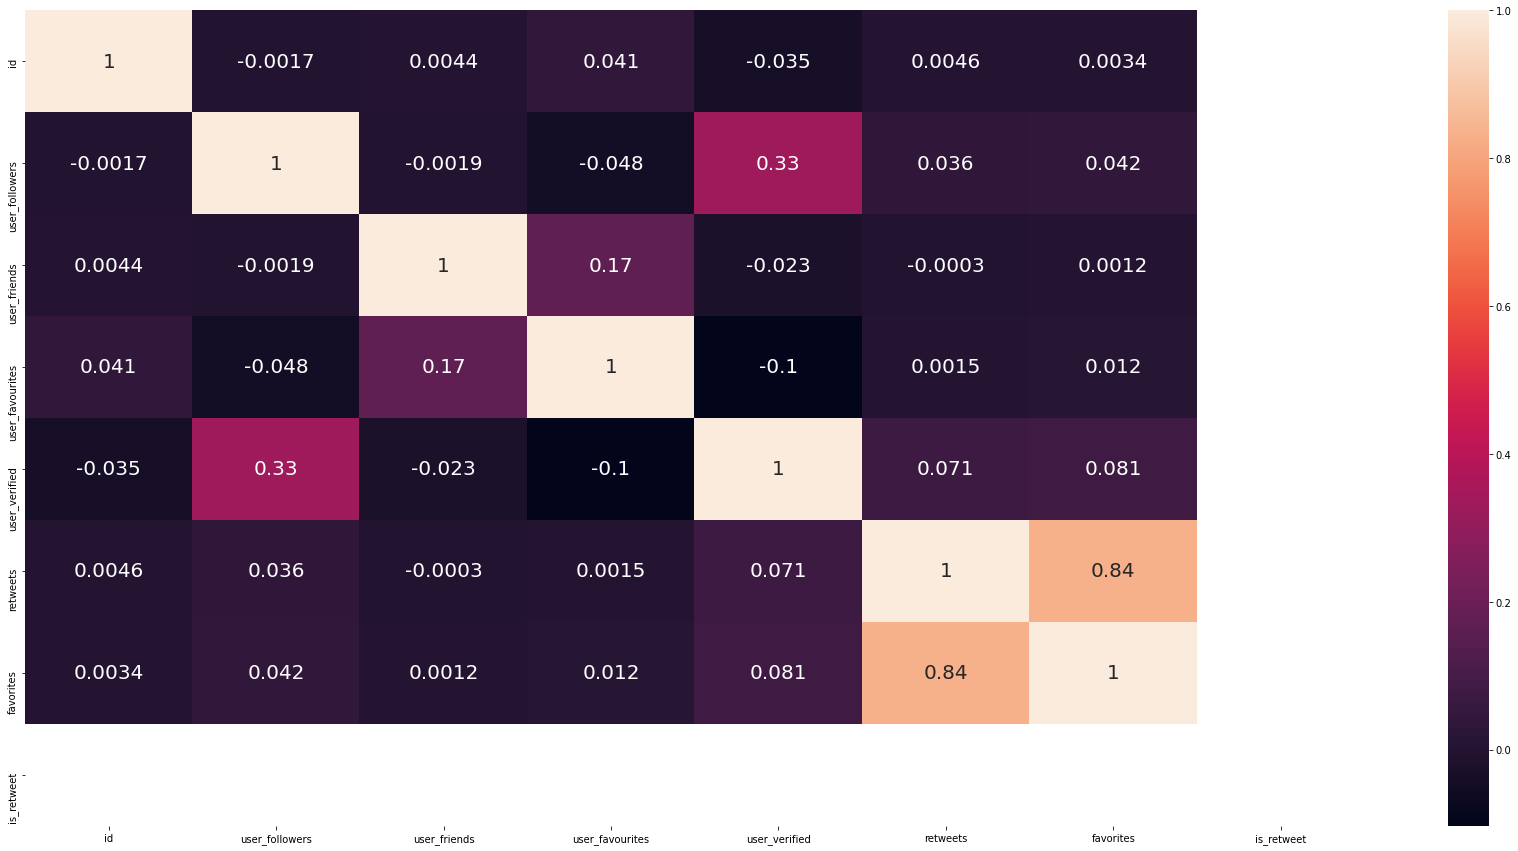

In [165]:
plt.figure(figsize=(30,15))
corrmatrix = df.corr()
print(sns.heatmap(corrmatrix, annot=True, annot_kws={'size':20}))

In [29]:
df.drop(axis=1, columns=['favorites'], inplace=True)

In [30]:
df.head()

,id,user_location,user_followers,user_friends,user_favourites,date,text,hashtags,retweets
0,1340539111971516416,"La Crescenta-Montrose, CA",405,1692,3247,2020-12-20,same folks said daikon paste could treat a cyt...,PfizerBioNTech,0
1,1338158543359250433,"San Francisco, CA",834,666,178,2020-12-13,while the world has been on the wrong side of ...,SputnikV,1
2,1337858199140118533,Your Bed,10,88,155,2020-12-12,coronavirus sputnikv astrazeneca pfizerbiontec...,"coronavirus, SputnikV, AstraZeneca, PfizerBioN...",0
3,1337855739918835717,"Vancouver, BC - Canada",49165,3933,21853,2020-12-12,facts are immutable senator even when youre no...,Covaxin,446
4,1337854064604966912,"[New Delhi, India]",152,580,1473,2020-12-12,explain to me again why we need a vaccine wher...,"whereareallthesickpeople, PfizerBioNTech",0


In [31]:
def sent_to_words(sentence):
  k1 = sentence.split()
  k1 = [wordnet.lemmatize(word) for word in k1 if not word in set(stopwords.words('english'))]
  k1 = ' '.join(k1)
  return k1

In [32]:
temp = df['text'].values.tolist()

In [ ]:
i=0
for sent in temp:
  df['text'][i] = sent_to_words(sent)
  i = i+1 

In [34]:
df['sentiment'] = svc.predict(df['text'])
df.head()

,id,user_location,user_followers,user_friends,user_favourites,date,text,hashtags,retweets,sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",405,1692,3247,2020-12-20,folk said daikon paste could treat cytokine st...,PfizerBioNTech,0,neutral
1,1338158543359250433,"San Francisco, CA",834,666,178,2020-12-13,world wrong side history year hopefully bigges...,SputnikV,1,positive
2,1337858199140118533,Your Bed,10,88,155,2020-12-12,coronavirus sputnikv astrazeneca pfizerbiontec...,"coronavirus, SputnikV, AstraZeneca, PfizerBioN...",0,negative
3,1337855739918835717,"Vancouver, BC - Canada",49165,3933,21853,2020-12-12,fact immutable senator even youre ethically st...,Covaxin,446,negative
4,1337854064604966912,"[New Delhi, India]",152,580,1473,2020-12-12,explain need vaccine whereareallthesickpeople ...,"whereareallthesickpeople, PfizerBioNTech",0,neutral


 # Sentiment Analysis

In [168]:
pos = df.loc[df['sentiment'] == 'positive']
neg = df.loc[df['sentiment'] == 'negative']
neut = df.loc[df['sentiment'] == 'neutral']
pos.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,is_retweet,sentiment
28,1337765770420506625,Emiliano Pacelli,"Rome, Italy",#IBMCloud and #AIApplications passionate helpi...,2019-07-29 20:03:23,75,291,685,False,2020-12-12 14:26:28,interesting and very detailed article showing ...,"['supplychain', 'sharedvisibility']",Twitter for iPad,0,False,positive
90,1338555378448076803,Aru Sivananthan 🇬🇧 🇦🇺,London,"Chair British #Tamil Conservatives, @BTConserv...",2009-07-03 18:47:06,1066,735,4213,False,2020-12-14 18:44:06,privileged be offered the vaccine. i would en...,['PfizerBioNTech'],Twitter for iPhone,1,False,positive
125,1338476299216695296,عماد الصالح,Al Khobar,‏‏في عيوني ريح توت وزعفران، وبجنوب القلب يملان...,2012-01-28 10:34:55,171,574,1091,False,2020-12-14 13:29:52,well done usa,"['PfizerBioNTech', 'Pfizervaccine', 'COVID19']",Twitter for Android,0,False,positive
143,1338443641027776515,Anita Raja,Birmingham UK,Doctor@NHS🏴󠁧󠁢󠁥󠁮󠁧󠁿MRCGP@RCGP Ex-TV presenter@pt...,2013-11-30 01:40:09,67,188,13,False,2020-12-14 11:20:05,excited about tomorrow so honoured to be part ...,['Covid_19'],Twitter for iPhone,0,False,positive
180,1338304176691040257,El Portal Tv Miami,"Palm Beach, FL",Todos pasan por Miami y yo me entero Casada co...,2018-11-07 23:35:48,332,891,15450,False,2020-12-14 02:05:54,be safe and thank you !!!,"['vaccine', 'FedEx', 'PfizerBioNTech', 'Pfizer']",Twitter for Android,0,False,positive


In [152]:
from wordcloud import STOPWORDS
def show_wordcloud(data, title = ""):
  text = " ".join(t for t in data)
  stopwords=set(STOPWORDS)
  stopwords.update(['thank', 'amp', 'pm', 'im'])
  wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=500,
        max_font_size=50, 
        scale=4,
    ).generate(text)

  fig = plt.figure(1, figsize=(16,16))
  plt.axis('off')
  fig.suptitle(title, fontsize=20)
  fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.show()

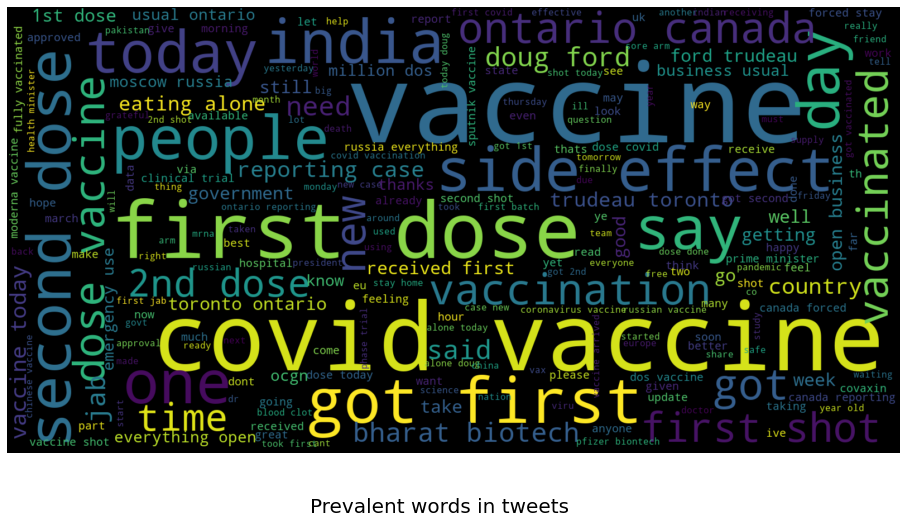

In [153]:
show_wordcloud(df['text'], title = 'Prevalent words in tweets')

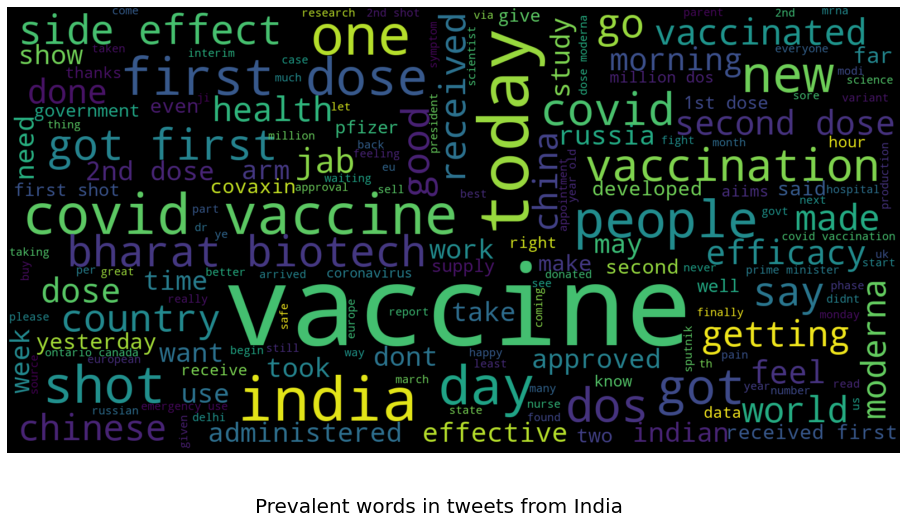

In [154]:
india_df = df.loc[df.user_location=="India"]
show_wordcloud(india_df['text'], title = 'Prevalent words in tweets from India')

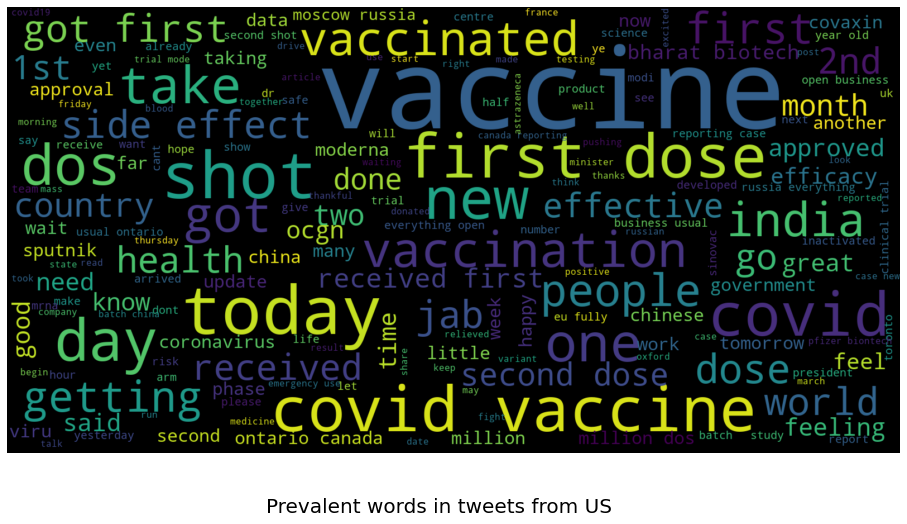

In [155]:
us_df = df.loc[df.user_location=="United States"]
show_wordcloud(us_df['text'], title = 'Prevalent words in tweets from US')

In [43]:
vax_tweets = df.copy(deep=True)
twts = df.copy(deep=True)

In [169]:
timeline = vax_tweets.groupby(['sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
print(timeline)

  sentiment  tweets
0  negative    8399
1   neutral   29992
2  positive    7004


In [177]:
import plotly.express as px
import plotly as pl
fig = px.bar(timeline, x='sentiment', y='tweets', color='sentiment')
fig.show()

In [44]:
timeline = twts.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
timeline.head()

,date,sentiment,tweets
0,2020-12-12,negative,19
1,2020-12-12,neutral,31
2,2020-12-12,positive,10
3,2020-12-13,negative,21
4,2020-12-13,neutral,57


In [42]:
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

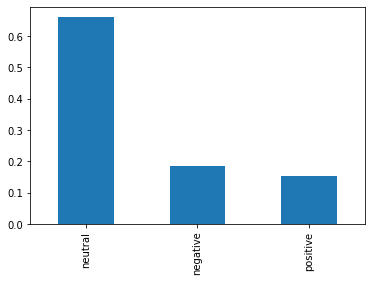

In [168]:
df['sentiment'].value_counts(normalize=True).plot.bar()

In [ ]:
f = {'hast':["[['Moderna']]", '[India]', "['whereareallthesickpeople', 'PfizerBioNTech']", "[['whereareallthesickpeople', 'PfizerBioNTech']]"],
      'fuel':[23, 34, 45, 56]}
gf = pd.DataFrame(f, columns=['hast', 'fuel'])
gf

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import reciprocal, uniform
#param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
#rnd_search_cv = RandomizedSearchCV(svc, param_distributions)
#rnd_search_cv.fit(X_train[:1000], y_train[:1000])

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

svc = Pipeline([('vect', CountVectorizer(ngram_range=[1,1])),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(C=10, gamma=1, random_state=42)),
                ])
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))

In [ ]:
def sent_to_words(sentences):
  l1 = []
  for sentence in sentences:
    l2 = sentence.split()
    l2 = [wordnet.lemmatize(word) for word in l2 if not word in set(stopwords.words('english'))]
    l2 = ' '.join(l2)
    l1.append(l2)
  return l1

data_words = sent_to_words(temp)

In [ ]:
'''vax_tweets = vax_tweets[['text']]
vax_tweets["sentiment"] = np.nan
vax_tweets.isnull().sum()'''

In [ ]:
'''param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)'''

In [ ]:
'''from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

logreg = Pipeline([('vect', CountVectorizer()),
                #('tfidf', TfidfTransformer()),
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(n_jobs=1, 
                                           C=1e5, 
                                           max_iter=1000)),
               ])
#X_train = scaler.transform(X_train)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy'''

In [ ]:
'''
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train, y_train)
model.score(x_test, y_test), model.predict(x_test)'''

In [ ]:
'''cv = TfidfVectorizer()
X = cv.fit_transform(data).toarray()
X.shape'''

In [ ]:
#X

In [ ]:
'''from sklearn.preprocessing import LabelEncoder 
le=LabelEncoder() 
y = le.fit_transform(tweets['sentiment'])'''

In [16]:
'''data = np.array(data_words)
data
cv = TfidfVectorizer()
X = cv.fit_transform(data).toarray()
from sklearn.preprocessing import LabelEncoder 
le=LabelEncoder() 
y = le.fit_transform(tweets['sentiment'])
from sklearn.naive_bayes import MultinomialNB
sentiment_model = MultinomialNB().fit(X_train, y_train)
y_pred = sentiment_model.predict(X_test)
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)'''

array(['i`d responded, going', 'sooo sad', 'bullying', ...,
       'yay good you.', 'worth ****.',
       'flirting going - atg smiles. yay. ((hugs)'], dtype='<U134')

In [ ]:
#y

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
'''from sklearn.naive_bayes import MultinomialNB
sentiment_model = MultinomialNB().fit(X_train, y_train)
y_pred = sentiment_model.predict(X_test)
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)'''

In [ ]:
#y=pd.get_dummies(tweets['sentiment'])
#y=y.iloc[:, 0:-1]

In [ ]:
#merged = pd.concat([tweets, y], axis='columns')
#merged

In [ ]:
#final = merged.drop(['sentiment', 'positive'], axis='columns')
#final

In [ ]:
'''from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df.target.values
)'''